# Modelo Completo

Como anexo a la práctica, voy a intentar construir el modelo completo de red neuronal. Usando variables sintéticas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.optimizers import Nadam
from keras.layers import Dropout
#from imblearn.under_sampling import NearMiss

import tensorflow as tf

#tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))


%matplotlib inline

Montamos Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos los datos:

In [41]:
datos_path = "/content/drive/My Drive/Docencia/UV-ML"
clientes_file = "Clientes_train.csv"
zonas_file = "Zonas.csv"

clientes = pd.read_csv(os.path.join(datos_path, clientes_file), sep='\t')
zonas = pd.read_csv(os.path.join(datos_path, zonas_file), sep='\t')

datos = pd.merge(clientes, zonas, on="ID_Zona", how="inner")



clientes_file_2 = "Clientes_test.csv"


clientes2 = pd.read_csv(os.path.join(datos_path, clientes_file_2), sep='\t')
zonas = pd.read_csv(os.path.join(datos_path, zonas_file), sep='\t')

datos2 = pd.merge(clientes2, zonas, on="ID_Zona", how="inner")

#targets2 = datos2["Seguro_Vivienda"]
#variables2 = datos2.drop(["Seguro_Vivienda"], axis=1, inplace=False)



X_test_2 = datos2._get_numeric_data()

In [42]:
datos.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Poblacion_Funcionario,Poblacion_Trabajador_Cualificado,Poblacion_Trabajador_No_Cualificado,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000
0,C3088,29/03/1968,27/03/1989,Mujer,Z1143,0,1,0,0.0,617.55,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
1,C3441,01/05/1962,26/12/1984,Hombre,Z1143,0,0,0,0.0,0.00,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
2,C0412,19/01/1967,29/04/1987,Hombre,Z1143,0,0,1,0.0,0.00,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
3,C3565,20/04/1948,06/09/1969,Hombre,Z1143,0,1,0,0.0,3315.54,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
4,C0315,28/07/1979,18/06/2001,Mujer,Z1143,0,1,2,0.0,2561.45,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3


In [43]:
datos2.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Poblacion_Funcionario,Poblacion_Trabajador_Cualificado,Poblacion_Trabajador_No_Cualificado,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000
0,C2172,05/10/1981,04/02/2005,Hombre,Z0403,1,2,2,735.14,2535.49,...,41.42,0.00,0.00,33.04,66.96,78.78,21.22,0.0,0.0,100.00
1,C3005,05/04/1974,26/11/1995,Hombre,Z0403,0,0,1,0.00,0.00,...,41.42,0.00,0.00,33.04,66.96,78.78,21.22,0.0,0.0,100.00
2,C1627,21/09/1983,27/12/2004,Mujer,Z0700,0,1,1,0.00,3195.94,...,46.35,16.59,1.30,0.00,100.00,31.24,68.76,0.0,0.0,100.00
3,C3120,16/02/1986,24/09/2007,Mujer,Z0700,0,3,0,0.00,4610.12,...,46.35,16.59,1.30,0.00,100.00,31.24,68.76,0.0,0.0,100.00
4,C0649,24/01/1945,02/12/1967,Hombre,Z1023,0,0,0,0.00,0.00,...,21.16,19.46,41.63,17.29,82.71,17.86,82.14,0.0,8.9,91.11


In [44]:
datos.describe()

,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,Gasto_Otros,Tipo_Familia,Tipo_Pareja,Tipo_Soltero,Educacion_Superior,...,Poblacion_Funcionario,Poblacion_Trabajador_Cualificado,Poblacion_Trabajador_No_Cualificado,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000
count,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,...,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000
mean,0.080287,0.750940,1.066279,37.133915,1583.312689,273.471145,47.392026,34.010779,18.597458,14.136502,...,29.345565,22.355572,26.771343,54.007017,45.992983,27.863485,72.136515,1.449713,6.700150,91.850126
std,0.365148,0.795887,1.001220,289.125502,2008.636888,741.281246,24.955844,20.001426,20.498031,18.661422,...,21.739949,20.322406,21.439939,37.375465,37.375465,24.390093,24.390093,5.362351,12.187754,14.078293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.410000,19.980000,0.000000,0.000000,...,15.230000,3.880000,9.420000,14.900000,8.175000,7.275000,56.530000,0.000000,0.000000,90.120000
50%,0.000000,1.000000,1.000000,0.000000,649.610000,117.630000,48.180000,32.140000,14.350000,6.440000,...,27.480000,19.550000,22.220000,58.410000,41.590000,20.570000,79.430000,0.000000,0.000000,99.990000
75%,0.000000,1.000000,2.000000,0.000000,2948.910000,303.705000,65.450000,44.705000,30.530000,20.700000,...,41.150000,33.700000,41.020000,91.825000,85.100000,43.470000,92.725000,0.000000,8.325000,100.000000
max,4.000000,10.000000,7.000000,4934.590000,16735.670000,17188.620000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.010000


In [45]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2926
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID_Cliente                           2927 non-null   object 
 1   Fecha_Nacimiento                     2927 non-null   object 
 2   Fecha_Alta                           2927 non-null   object 
 3   Sexo                                 2927 non-null   object 
 4   ID_Zona                              2927 non-null   object 
 5   Productos_Vida                       2927 non-null   int64  
 6   Productos_Vehiculos                  2927 non-null   int64  
 7   Productos_Otros                      2927 non-null   int64  
 8   Gasto_Vida                           2927 non-null   float64
 9   Gasto_Vehiculos                      2927 non-null   float64
 10  Gasto_Otros                          2927 non-null   float64
 11  Seguro_Vivienda               


Creamos variables sintéticas para ámbas tablas: Edad (años) y Antiguedad (meses):

In [46]:

datos['Edad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Nacimiento, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'Y')).astype(int)

datos['Antiguedad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Alta, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'M')).astype(int)

datos['Sexo_2'] = 0
datos['Sexo_2'][datos.Sexo=='Hombre'] =1


datos2['Edad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Nacimiento, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'Y')).astype(int)

datos2['Antiguedad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Alta, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'M')).astype(int)

datos2['Sexo_2'] = 0
datos2['Sexo_2'][datos2.Sexo=='Hombre'] =1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
datos.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
0,C3088,29/03/1968,27/03/1989,Mujer,Z1143,0,1,0,0.0,617.55,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,50,354,0
1,C3441,01/05/1962,26/12/1984,Hombre,Z1143,0,0,0,0.0,0.00,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,56,405,1
2,C0412,19/01/1967,29/04/1987,Hombre,Z1143,0,0,1,0.0,0.00,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,51,377,1
3,C3565,20/04/1948,06/09/1969,Hombre,Z1143,0,1,0,0.0,3315.54,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,70,588,1
4,C0315,28/07/1979,18/06/2001,Mujer,Z1143,0,1,2,0.0,2561.45,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,39,207,0


In [48]:
datos2.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
0,C2172,05/10/1981,04/02/2005,Hombre,Z0403,1,2,2,735.14,2535.49,...,33.04,66.96,78.78,21.22,0.0,0.0,100.00,50,354,1
1,C3005,05/04/1974,26/11/1995,Hombre,Z0403,0,0,1,0.00,0.00,...,33.04,66.96,78.78,21.22,0.0,0.0,100.00,56,405,1
2,C1627,21/09/1983,27/12/2004,Mujer,Z0700,0,1,1,0.00,3195.94,...,0.00,100.00,31.24,68.76,0.0,0.0,100.00,51,377,0
3,C3120,16/02/1986,24/09/2007,Mujer,Z0700,0,3,0,0.00,4610.12,...,0.00,100.00,31.24,68.76,0.0,0.0,100.00,70,588,0
4,C0649,24/01/1945,02/12/1967,Hombre,Z1023,0,0,0,0.00,0.00,...,17.29,82.71,17.86,82.14,0.0,8.9,91.11,39,207,1


Preparamos la tabla para entrenar

### Remuestreo

In [49]:
datos_ext = datos

for i in range(0,3):
    datos_ext = datos_ext.append(datos_ext[datos_ext.Seguro_Vivienda==1])

datos_ext[datos_ext.Seguro_Vivienda==1]
#datos_ext

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
11,C1947,10/09/1948,08/09/1973,Hombre,Z1201,1,0,2,492.21,3890.19,...,92.04,7.96,43.84,56.16,0.00,3.38,96.62,70,540,1
34,C2877,05/11/1966,19/11/1988,Hombre,Z0789,0,1,3,0.00,6712.59,...,100.00,0.00,20.08,79.92,0.00,0.00,100.00,51,358,1
41,C1031,04/02/1980,20/01/2001,Mujer,Z0789,0,1,2,0.00,6824.90,...,100.00,0.00,20.08,79.92,0.00,0.00,100.00,38,212,0
60,C1093,29/10/1948,18/03/1970,Hombre,Z0664,0,1,2,0.00,5915.24,...,16.11,83.89,1.91,98.09,0.00,0.00,100.01,69,582,1
69,C3214,03/03/1948,02/09/1970,Hombre,Z1707,0,1,2,0.00,6262.06,...,100.00,0.00,70.70,29.30,16.02,12.17,71.81,70,577,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842,C1554,16/09/1949,14/04/1971,Hombre,Z0854,0,2,2,0.00,7684.82,...,100.00,0.00,53.53,46.47,0.00,0.00,100.00,69,569,1
2844,C1123,16/11/1953,13/06/1974,Hombre,Z0848,0,1,2,0.00,4981.78,...,100.00,0.00,71.88,28.12,0.00,44.90,55.10,64,531,1
2855,C0547,05/01/1986,15/08/2009,Mujer,Z0322,0,1,2,0.00,6977.63,...,42.43,57.57,46.11,53.89,0.00,29.79,70.21,32,109,0
2894,C3732,20/11/1965,30/12/1986,Hombre,Z0112,0,1,2,0.00,8357.03,...,1.04,98.96,0.00,100.00,0.00,1.26,98.74,52,381,1


In [50]:
targets = datos["Seguro_Vivienda"]
variables = datos.drop(["Seguro_Vivienda", "ID_Cliente", "Fecha_Nacimiento", "Fecha_Alta", "Sexo", "ID_Zona"], axis=1, inplace=False)

In [51]:
targets.head()

0    False
1    False
2    False
3    False
4    False
Name: Seguro_Vivienda, dtype: bool

In [52]:
variables.head()

,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,Gasto_Otros,Tipo_Familia,Tipo_Pareja,Tipo_Soltero,Educacion_Superior,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
0,0,1,0,0.0,617.55,0.00,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,50,354,0
1,0,0,0,0.0,0.00,0.00,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,56,405,1
2,0,0,1,0.0,0.00,197.14,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,51,377,1
3,0,1,0,0.0,3315.54,0.00,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,70,588,1
4,0,1,2,0.0,2561.45,176.94,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,39,207,0


In [53]:

X_train, X_test, y_train, y_test = train_test_split(
    variables, targets, test_size=0.2, random_state=42)

y_train = y_train*1
y_test = y_test*1

#### Escalado

In [54]:

scale = StandardScaler()

X_scale_train = scale.fit_transform(X_train)
X_scale_test = scale.transform(X_test)

#X_scale_train = X_scale_train.reshape((len(X_scale_train), np.prod(X_scale_train.shape[1:])))
#X_scale_test = X_scale_test.reshape((len(X_scale_test), np.prod(X_scale_test.shape[1:])))

#y_cat_train = y_train*1
#y_cat_test = y_test*1

#Necesitamos este paso para poder probar con dos neuronas en la última capa
y_cat_train = to_categorical(y_train.astype(int))
y_cat_test = to_categorical(y_test.astype(int))

#y_cat_train[1:50]
#y_train[1:50]

## Red Neuronal

In [55]:
# por lo que veo en las últimas versiones han quitado alguna métrica de Keras, pero en esta ruta están implementadas muchas:
# https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
# tengo dudas si el recall es correcto, pero luego saldremos de dudas cuando veamos las curvas ROC en el siguiente notebook

from keras import backend as K

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score



In [56]:
def model():

  l=0.01
  rate = 0.50
  x = Input(shape=(26,))
  layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(x)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(50, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  y = Dense(1, activation='sigmoid',kernel_initializer='he_uniform')(layer)
  mlp = Model(x, y)
  #nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

  mlp.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', recall, fbeta_score])
  return mlp

In [57]:
mlp= model()

callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)]

In [58]:
mlp.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_10 (Dense)            (None, 100)               2700      
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                           

In [59]:
history=mlp.fit(X_scale_train, y_train,
                epochs=500,
                batch_size=128,
                shuffle=True,
                callbacks = callback,
                 validation_split=0.1)

Epoch 1/500
17/17 [==============================] - 2s 28ms/step - loss: 37.5493 - accuracy: 0.5356 - recall: 0.4832 - fbeta_score: 0.1113 - val_loss: 37.0464 - val_accuracy: 0.7064 - val_recall: 0.7333 - val_fbeta_score: 0.2265
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 36.9960 - accuracy: 0.5897 - recall: 0.5028 - fbeta_score: 0.1149 - val_loss: 36.5137 - val_accuracy: 0.8340 - val_recall: 0.6333 - val_fbeta_score: 0.3075
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 36.4665 - accuracy: 0.6244 - recall: 0.3280 - fbeta_score: 0.0955 - val_loss: 36.0005 - val_accuracy: 0.8809 - val_recall: 0.4667 - val_fbeta_score: 0.3030
Epoch 4/500
17/17 [==============================] - 0s 8ms/step - loss: 35.9334 - accuracy: 0.6809 - recall: 0.3838 - fbeta_score: 0.1328 - val_loss: 35.4990 - val_accuracy: 0.9149 - val_recall: 0.3111 - val_fbeta_score: 0.2917
Epoch 5/500
17/17 [==============================] - 0s 7ms/step - loss: 35.4220 - 

In [60]:
mlp.evaluate(X_scale_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 0.7620 - accuracy: 0.9522 - recall: 0.1184 - fbeta_score: 0.1421


[0.7620288133621216,
 0.9522184133529663,
 0.1184210553765297,
 0.14210525155067444]

### ROC

In [61]:
y_score = mlp.predict(X_scale_test)
#y_score =y_score[:,1]>y_score[:,0]
y_score[0:100]
#y_test[0:100]

roc_auc_score(y_test, y_score)

19/19 [==============================] - 0s 2ms/step


0.9314914198635129

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(y_test, y_score.round(0) ))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       559
           1       0.45      0.19      0.26        27

    accuracy                           0.95       586
   macro avg       0.71      0.59      0.62       586
weighted avg       0.94      0.95      0.94       586



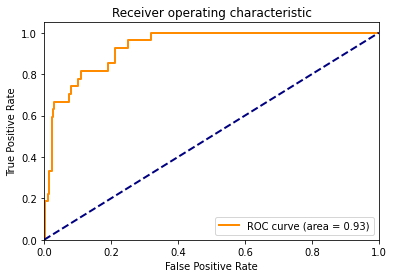

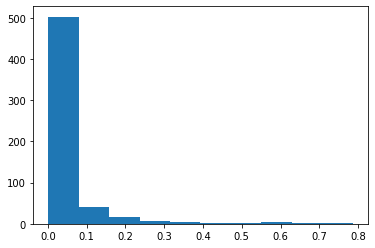

In [63]:
# Compute ROC curve and ROC area for each class



# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.hist(y_score)
plt.show()

Bastante similar al modelo de una capa, esto me hace pensar que la opción "class_weight='balanced'" funciona bastante bien.

In [64]:
# list all data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'recall', 'fbeta_score', 'val_loss', 'val_accuracy', 'val_recall', 'val_fbeta_score'])


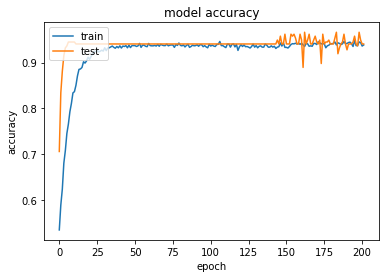

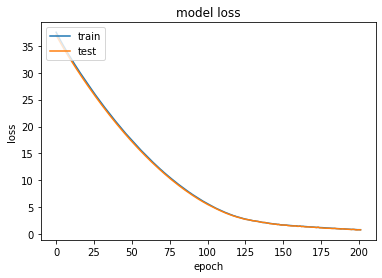

In [65]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Regresión Logística

In [66]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='liblinear',
                         multi_class='auto').fit(X_train, y_train)


In [37]:
clf.score(X_test, y_test)

0.9573378839590444

In [67]:
y_score = clf.predict_proba(X_test)
#y_test[0:100]

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(y_test, clf.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       559
           1       0.56      0.33      0.42        27

    accuracy                           0.96       586
   macro avg       0.77      0.66      0.70       586
weighted avg       0.95      0.96      0.95       586



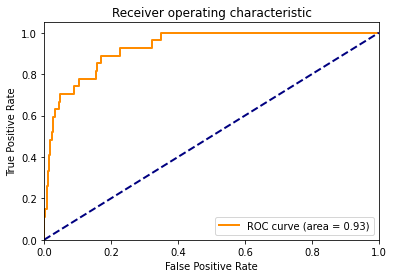

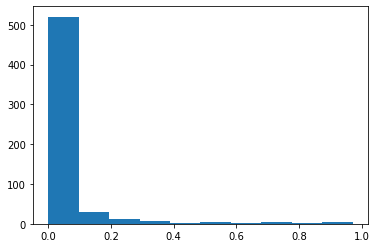

In [40]:


roc_auc_score(y_test, y_score[:,1])



# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.hist(y_score[:,1])
plt.show()

In [ ]:
y_test

2390    0
196     0
2307    0
1731    0
1100    0
1192    0
1505    0
1159    0
322     0
1350    0
2177    0
211     0
2922    0
2906    0
1744    0
2260    0
554     0
642     1
511     1
2858    0
2149    0
1316    0
439     0
1360    1
783     0
1486    0
1474    0
2657    0
471     0
744     0
       ..
1027    0
1940    0
1064    0
2136    0
862     0
1477    0
1795    0
2838    0
358     0
2089    0
2496    0
259     0
685     0
2334    0
2384    0
2096    0
2349    0
842     0
1395    0
844     0
2651    0
2266    0
456     0
462     0
2166    0
2443    0
381     0
1780    0
962     0
1939    0
Name: Seguro_Vivienda, Length: 586, dtype: int64

In [ ]:
y_score[:,1]

array([5.12415073e-03, 3.90401473e-05, 4.01182705e-03, 8.03686715e-03,
       9.68723530e-03, 3.62356211e-03, 4.07231717e-03, 4.31103909e-04,
       5.35840607e-04, 5.04627908e-03, 8.55902688e-03, 1.00264922e-02,
       1.01381899e-02, 4.76149997e-03, 1.83036397e-03, 6.96488555e-03,
       4.13280919e-03, 3.97063078e-01, 7.36326667e-02, 4.28302923e-03,
       6.18761737e-03, 1.97105975e-03, 4.60737713e-03, 3.90750101e-02,
       4.51723036e-03, 4.00525765e-03, 5.33632353e-03, 6.63521005e-04,
       2.90176060e-03, 1.97857747e-02, 7.76020373e-01, 4.77160971e-04,
       5.85020922e-03, 1.27446650e-02, 4.86956617e-03, 6.56511103e-04,
       3.77738764e-03, 6.49126131e-02, 5.83857344e-03, 3.39308883e-03,
       7.41832594e-03, 1.21823571e-02, 5.55265625e-03, 6.70785805e-03,
       1.25511581e-01, 1.13088345e-02, 4.78115421e-03, 4.67279765e-02,
       4.68194460e-02, 3.25750100e-04, 1.79992408e-03, 2.55802237e-01,
       9.82689219e-03, 4.09108249e-03, 1.81728000e-01, 1.86723746e-01,
      